In [1]:
import numpy as np
import pandas as pd
pd.set_option("precision", 3)
import matplotlib.pyplot as plt
from funcs.fitting import loss_single_seg
from datetime import datetime
from funcs.models import model_ND
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('data/stoke_delta_t.csv', comment='#')
df = df.dropna() 
df['time'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
df['timestamp'] = df['time'].values.astype(np.int64)//10**9 # Add a timestamp column, measured in seconds
cols = ['outside','1N','2N','3N','4N','BMS'] # select a subset of columns
df['gas'] *= 0.5e3/(3600) #*4e1 # convert kW*h to W*s (factor of 2 for 1/2 hour?)
df.describe()

,outside,1N,1S,2N,2S,3N,3S,4N,4S,BMS,gas,timestamp
count,3336.000,3336.00,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3.336e+03
mean,6.143,18.75,20.830,21.625,22.438,21.521,21.609,21.072,20.984,21.109,11.269,1.580e+09
std,2.190,1.14,1.001,0.772,0.892,0.926,0.835,0.972,0.943,0.750,4.320,1.734e+06
min,-0.100,16.70,17.100,20.000,20.000,19.800,19.900,17.500,17.500,19.100,0.000,1.577e+09
25%,4.700,17.80,20.100,21.200,21.800,21.000,21.100,20.300,20.200,20.500,9.444,1.578e+09
50%,6.300,18.80,20.700,21.700,22.400,21.600,21.600,21.100,20.900,21.100,10.972,1.580e+09
75%,7.600,19.50,21.400,22.200,23.100,22.200,22.200,21.800,21.700,21.625,13.472,1.581e+09
max,11.400,22.50,24.100,23.600,24.800,23.800,24.000,23.700,23.600,23.400,35.972,1.583e+09


#### Below is all temperature readings stacked, between 2019-12-19 and 2019-12-30

[Text(0, 0.5, 'Temperature (C)'), (18249.0, 18260.0)]

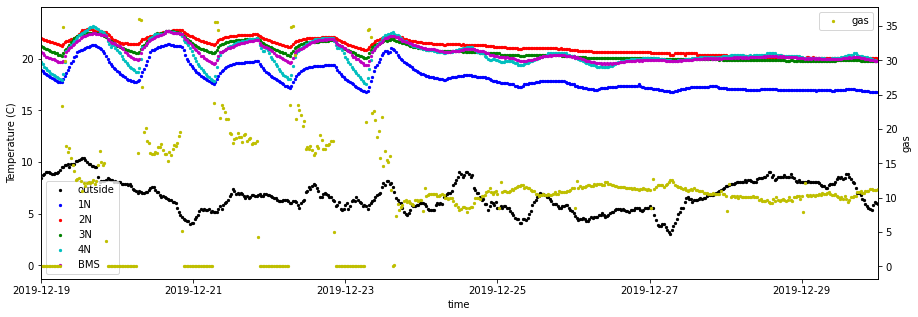

In [3]:
# define two time ranges to plot over
fmt = '%Y-%m-%dT%H:%M:%S.%f'
xlim1 = [datetime.strptime(time, fmt) for time in ['2020-02-13T00:00:00.00','2020-02-15T00:00:00.00']]
xlim2 = [datetime.strptime(time, fmt) for time in ['2019-12-19T00:00:00.00','2019-12-30T00:00:00.00']]
fig, ax = plt.subplots(1,1, figsize=(15,5))
colors = 'kbrgcm'
for i, col in enumerate(cols):
    df.plot(x='time', y=col, kind='scatter', s=5, ax=ax, label=col, color=colors[i])
ax2 = ax.twinx()
df.plot(x='time', y='gas', kind='scatter', s=5, ax=ax2, color='y', label='gas')
ax.set(ylabel = 'Temperature (C)', xlim=xlim2) 
# ax.legend()

In [4]:
# optimiser args
bounds = ((None,None),(None,None),(15,25))#((5e1,1e2),(1.5e7,2.5e7),(15,25))
tolerance = 1e-20

# results
results_str = '\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}\nT1:\t{:,.5f}\t\t{:,.5f}'

## Modelling data for room 1 with our single segment model

In [5]:
times, Ts_true, Q_in, T_out = df[['timestamp','1N','gas','outside']].head(500).values.T
times = (times-times[0])

In [6]:
# Initial guesses for scipy.optimize.minimize
k0 = 0.8
c0 = 1e5
T0 = 20.0
initial_params = np.array([k0, c0, T0])

In [7]:
sys_guess = model_ND('Initial guess', k0, c0, T0, T_out, Q_in)
T_guess = sys_guess.run(times=times).flatten()

	Initial			Estimated
k1:	0.80000			0.97147
c1:	100,000.00		161,487.81
T1:	20.00000		20.25307


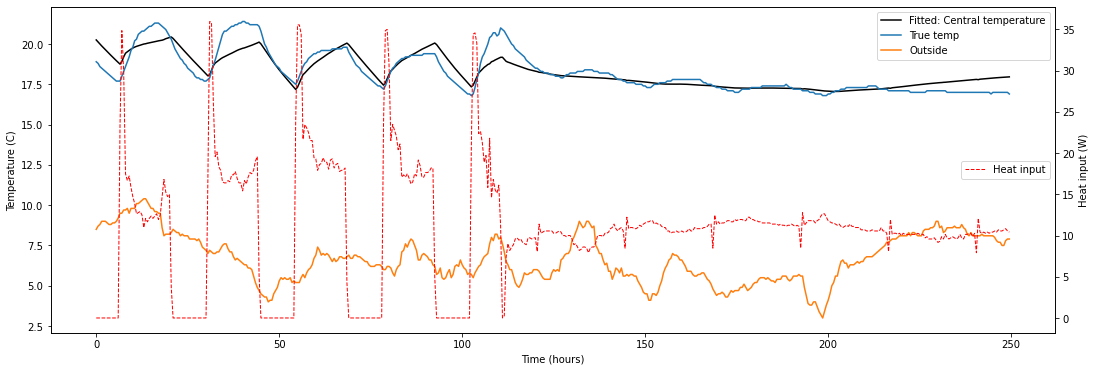

In [8]:
result = minimize(loss_single_seg, x0=initial_params, tol=tolerance, args=('mse', times, Ts_true, T_out, Q_in), bounds=bounds)
k_est, c_est, T_est = result['x']
print(results_str.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation. 
Ts = sys_fit.run(times=times).flatten()


fig, ax = sys_fit.plot()
# sys_guess.plot(figax=(fig,ax), ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 2 with our single segment model

In [9]:
times, Ts_true, Q_in, T_out = df[['timestamp','2N','gas','outside']].head(500).values.T
times = (times-times[0])

	Initial			Estimated
k1:	0.80000			0.79332
c1:	100,000.00		325,724.23
T1:	20.00000		22.54996


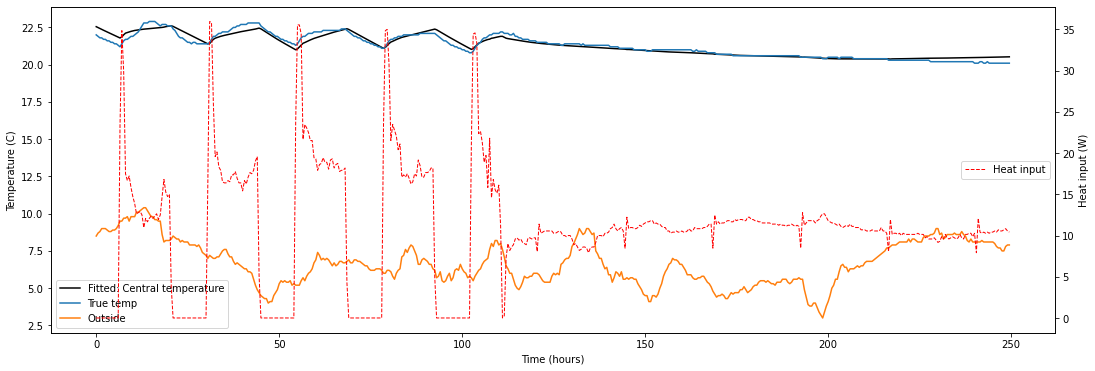

In [10]:
result = minimize(loss_single_seg, x0=initial_params, tol=tolerance, args=('mse', times, Ts_true, T_out, Q_in), bounds=bounds)
k_est, c_est, T_est = result['x']
print(results_str.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=(fig,ax), ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 3 with our single segment model

In [11]:
times, Ts_true, Q_in, T_out = df[['timestamp','3N','gas','outside']].head(500).values.T
times = (times-times[0])

	Initial			Estimated
k1:	0.80000			0.80432
c1:	100,000.00		236,629.42
T1:	20.00000		22.04739


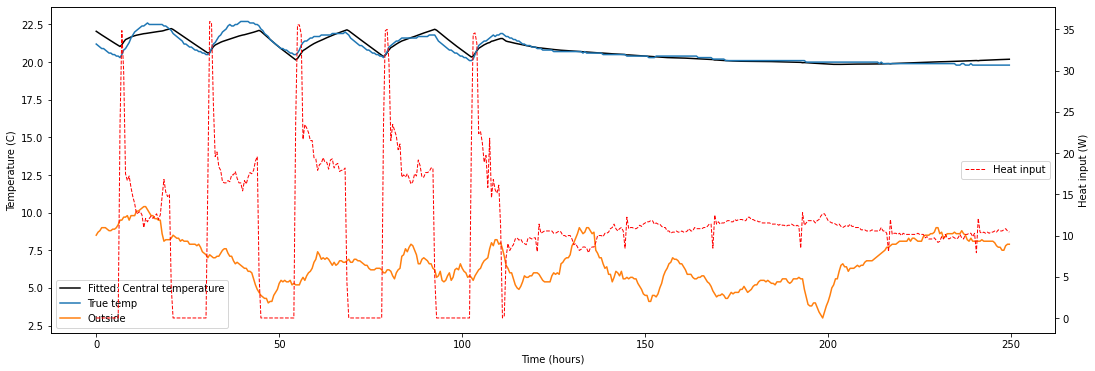

In [12]:
result = minimize(loss_single_seg, x0=initial_params, tol=tolerance, args=('mse', times, Ts_true, T_out, Q_in), bounds=bounds)
k_est, c_est, T_est = result['x']
print(results_str.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 4 with our single segment model

In [13]:
times, Ts_true, Q_in, T_out = df[['timestamp','4N','gas','outside']].head(500).values.T
times = (times-times[0])

	Initial			Estimated
k1:	0.80000			0.79105
c1:	100,000.00		100,000.00
T1:	20.00000		21.00597


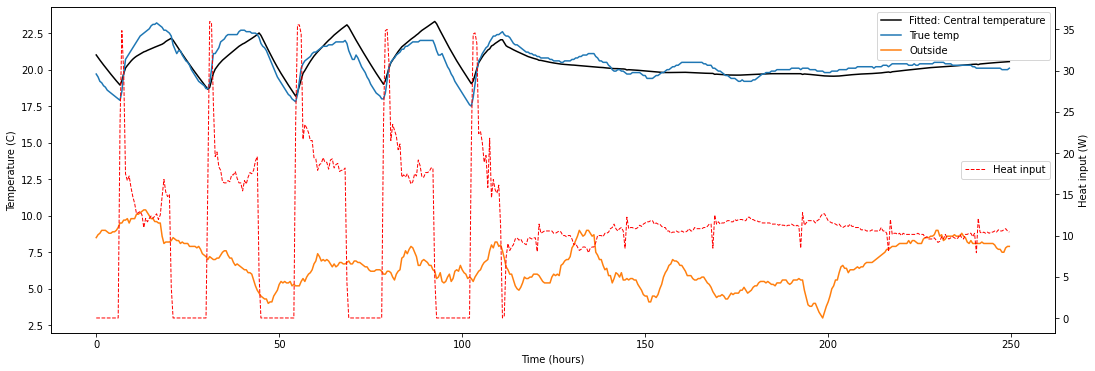

In [14]:
result = minimize(loss_single_seg, x0=initial_params, tol=tolerance, args=('mse', times, Ts_true, T_out, Q_in), bounds=bounds)
k_est, c_est, T_est = result['x']
# k_est, c_est, T_est = k0, c0, T0
print(results_str.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 3 with our two segment model

In [16]:
from funcs.fitting import loss_two_seg

In [42]:
times, Q_in, T_out = df[['timestamp','gas','outside']].head(500).values.T
Ts_true = df[['1N','4N']].head(500).values
times = (times-times[0])

In [67]:
# Initial guesses for scipy.optimize.minimize
k0 = [1, 3]
c0 = [6e5, 6e5]
T0 = Ts_true[0]
initial_params = np.array([*k0, *c0])
# bounds = ((0.1,100),(0.1,100),(5e3,5e4),(5e4,5e5))
bounds = ((None, None), (None,None), (None,None), (None,None))

In [68]:
# sys_guess = model_ND('Initial guess', k0, c0, T0, T_out, Q_in)
# T_guess = sys_guess.run(times=times).flatten()

	Initial			Estimated		
k1:	1.00000			318.72091
k2:	3.00000			0.91645
c1:	600000.00000		600000.00046
c2:	600000.00000		600000.00040


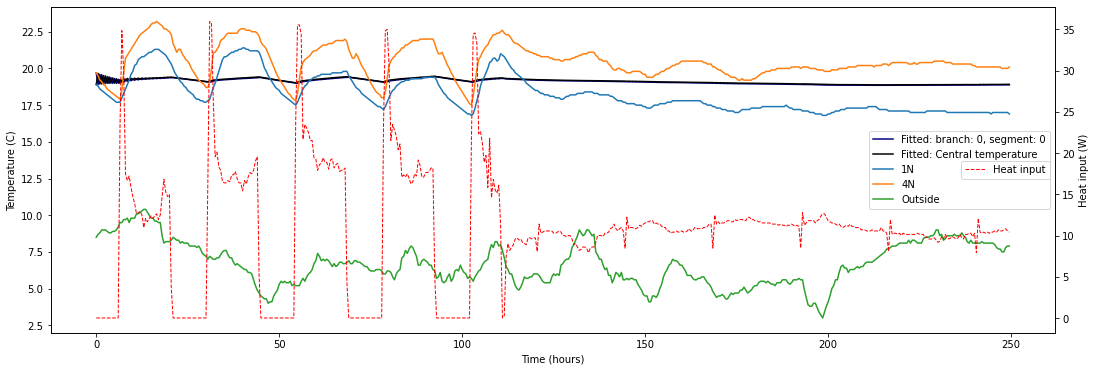

In [69]:
result = minimize(loss_two_seg, x0=initial_params, tol=tolerance, args=('mse', times, T0, Ts_true, T_out, Q_in), bounds=bounds)
k_est, c_est = result['x'].reshape(2,-1)
results_str = '\tInitial\t\t\tEstimated\t\t\nk1:\t{:.5f}\t\t\t{:.5f}\nk2:\t{:.5f}\t\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}'
print(results_str.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T0, T_out, Q_in)
# Run simulation.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# fig, ax = sys_guess.plot(figax=None, ls='-.');
ax.plot(times/3600, Ts_true[:,0], label='1N')
ax.plot(times/3600, Ts_true[:,1], label='4N')
ax.plot(times/3600, T_out, label='Outside')
ax.legend();

In [21]:
Ts_true[0]

array([18.9, 19.7])